# Data Exploration

### Imports


In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import platform


<div class="alert alert-block alert-warning">
<b>Dask:</b> Multiprocessing package that can be used for (almost all) Pandas & Scikit-learn functionality.
 Ships with Anaconda, but not with MiniConda.
</div>

In [2]:
# from sklearn.grid_search import GridSearchCV
#from dklearn.grid_search import GridSearchCV   # voorbeeld van dklearn => dit gaan we zeker nodig hebben bij hyperopt etc.
# from dask.distributed import Client
# client = Client() # often http://localhost:8787/status

### Load Data In

In [3]:
path_dominic = 'C:/Users/doist/OneDrive/Documenten/Business Analytics/Master/Year 1/Data Mining Techniques/Assignment 2/Data/'
path_titus = '2nd-assignment-dmt-2021/'
path_jaimie = 'C:/Users/Jaimie/Documents/VU/Master jaar 1/'

use_dominic = False
dir = path_dominic if use_dominic else path_titus

if platform.node() == 'DESKTOP-5JGA1BG':
    dir = path_jaimie
    
df = pd.read_csv(dir+'training_set_VU_DM.csv', parse_dates=['date_time'])
display(df)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958342,332785,2013-06-30 19:55:18,5,219,NaN,NaN,219,77700,3,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
4958343,332785,2013-06-30 19:55:18,5,219,NaN,NaN,219,88083,3,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
4958344,332785,2013-06-30 19:55:18,5,219,NaN,NaN,219,94508,3,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
4958345,332785,2013-06-30 19:55:18,5,219,NaN,NaN,219,128360,3,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,157.84,1


In [4]:
mem_size = df.memory_usage(index=True).sum() / 1_024**2

print(f"Size in Memory: {mem_size:.0f} MB")

Size in Memory: 2043 MB


In [5]:
# Inspect inferred types
display(df.dtypes)

# Inspect numerical ranges
display(df.describe())
# print('Min. Values')
# print(df.min())
#
# print('Max. Values')
# print(df.max())

srch_id                                 int64
date_time                      datetime64[ns]
site_id                                 int64
visitor_location_country_id             int64
visitor_hist_starrating               float64
visitor_hist_adr_usd                  float64
prop_country_id                         int64
prop_id                                 int64
prop_starrating                         int64
prop_review_score                     float64
prop_brand_bool                         int64
prop_location_score1                  float64
prop_location_score2                  float64
prop_log_historical_price             float64
position                                int64
price_usd                             float64
promotion_flag                          int64
srch_destination_id                     int64
srch_length_of_stay                     int64
srch_booking_window                     int64
srch_adults_count                       int64
srch_children_count               

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
count,4.958347e+06,4.958347e+06,4.958347e+06,251866.000000,252988.000000,4.958347e+06,4.958347e+06,4.958347e+06,4.950983e+06,4.958347e+06,...,96174.000000,315348.000000,356422.000000,138515.000000,1.916654e+06,1.987503e+06,614730.000000,4.958347e+06,138390.000000,4.958347e+06
mean,1.663666e+05,9.953133e+00,1.753405e+02,3.374334,176.022659,1.739739e+02,7.007918e+04,3.180525e+00,3.777777e+00,6.346994e-01,...,17.250473,0.145969,0.083202,19.433267,-6.089936e-02,9.962752e-03,22.430384,4.474858e-02,386.283316,2.791051e-02
std,9.611223e+04,7.646890e+00,6.591625e+01,0.692519,107.254493,6.834525e+01,4.060992e+04,1.051024e+00,1.050329e+00,4.815144e-01,...,31.160313,0.578202,0.316722,54.370221,4.691723e-01,2.029142e-01,895.965854,2.067514e-01,821.190577,1.647165e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.410000,0.000000,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.000000,-1.000000,-1.000000,2.000000,-1.000000e+00,-1.000000e+00,2.000000,0.000000e+00,0.000000,0.000000e+00
25%,8.293600e+04,5.000000e+00,1.000000e+02,2.920000,109.810000,1.000000e+02,3.501000e+04,3.000000e+00,3.500000e+00,0.000000e+00,...,6.000000,0.000000,0.000000,7.000000,0.000000e+00,0.000000e+00,7.000000,0.000000e+00,124.000000,0.000000e+00
50%,1.665070e+05,5.000000e+00,2.190000e+02,3.450000,152.240000,2.190000e+02,6.963800e+04,3.000000e+00,4.000000e+00,1.000000e+00,...,11.000000,0.000000,0.000000,12.000000,0.000000e+00,0.000000e+00,11.000000,0.000000e+00,218.400000,0.000000e+00
75%,2.497240e+05,1.400000e+01,2.190000e+02,3.930000,213.490000,2.190000e+02,1.051680e+05,4.000000e+00,4.500000e+00,1.000000e+00,...,18.000000,1.000000,0.000000,20.000000,0.000000e+00,0.000000e+00,17.000000,0.000000e+00,429.790000,0.000000e+00
max,3.327850e+05,3.400000e+01,2.310000e+02,5.000000,1958.700000,2.300000e+02,1.408210e+05,5.000000e+00,5.000000e+00,1.000000e+00,...,1620.000000,1.000000,1.000000,9900.000000,1.000000e+00,1.000000e+00,149400.000000,1.000000e+00,159292.380000,1.000000e+00


In [6]:
print(df['booking_bool'].value_counts())

0    4819957
1     138390
Name: booking_bool, dtype: int64


In [7]:
# data types

# # memory + speed improvements
# optimal_dtypes = {'srch_id': np.uint32,
#                   'site_id': np.uint32,
#                   'visitor_location_country_id': np.uint8,
#                   'prop_country_id': np.uint8,
#                   'prop_id': np.uint32,
#                   'prop_starrating': np.uint8,
#                   'prop_brand_bool': np.uint8,
#                   'promotion_flag': (np.uint8,
#                   'srch_destination_id': np.uint16,
#                   'srch_length_of_stay': np.uint16,
#                   'srch_booking_window': np.uint16,
#                   'srch_adults_count': np.uint8,
#                   'srch_children_count': np.uint8,  # 255 kids max should suffice
#                   'srch_room_count': np.uint8,
#                   'srch_saturday_night_bool': np.uint8,
#                   'random_bool': np.uint8,
#                   'position': np.uint8,
#                   'click_bool': np.uint8,
#                   'booking_bool': np.uint8}
#
# for i in range(1, 9):
#     optimal_dtypes[f'comp{i}_rate'] = np.int8,
#     optimal_dtypes[f'comp{i}_inv'] = np.int8,     # assignment does not specify -1 but is exists??
#     # competitor_dtypes[f'comp{i}_rate_percent_diff'] = np.uint


# dfn = df.dtypes(optimal_dtypes)
# print(dfn.dtypes)


## Exploration

### Count of unique values per column:

In [8]:
uniques = df.nunique()
display(uniques)

srch_id                        199795
date_time                      198615
site_id                            34
visitor_location_country_id       210
visitor_hist_starrating           312
visitor_hist_adr_usd             7799
prop_country_id                   172
prop_id                        129113
prop_starrating                     6
prop_review_score                  10
prop_brand_bool                     2
prop_location_score1              337
prop_location_score2             9342
prop_log_historical_price         392
position                           40
price_usd                       76465
promotion_flag                      2
srch_destination_id             18127
srch_length_of_stay                36
srch_booking_window               429
srch_adults_count                   9
srch_children_count                10
srch_room_count                     8
srch_saturday_night_bool            2
srch_query_affinity_score      199387
orig_destination_distance      530595
random_bool 

### % missing values per column

srch_id                         0.000000
date_time                       0.000000
site_id                         0.000000
visitor_location_country_id     0.000000
visitor_hist_starrating        94.920364
visitor_hist_adr_usd           94.897735
prop_country_id                 0.000000
prop_id                         0.000000
prop_starrating                 0.000000
prop_review_score               0.148517
prop_brand_bool                 0.000000
prop_location_score1            0.000000
prop_location_score2           21.990151
prop_log_historical_price       0.000000
position                        0.000000
price_usd                       0.000000
promotion_flag                  0.000000
srch_destination_id             0.000000
srch_length_of_stay             0.000000
srch_booking_window             0.000000
srch_adults_count               0.000000
srch_children_count             0.000000
srch_room_count                 0.000000
srch_saturday_night_bool        0.000000
srch_query_affin

Non-missing columns:


['srch_id',
 'date_time',
 'site_id',
 'visitor_location_country_id',
 'prop_country_id',
 'prop_id',
 'prop_starrating',
 'prop_brand_bool',
 'prop_location_score1',
 'prop_log_historical_price',
 'position',
 'price_usd',
 'promotion_flag',
 'srch_destination_id',
 'srch_length_of_stay',
 'srch_booking_window',
 'srch_adults_count',
 'srch_children_count',
 'srch_room_count',
 'srch_saturday_night_bool',
 'random_bool',
 'click_bool',
 'booking_bool']

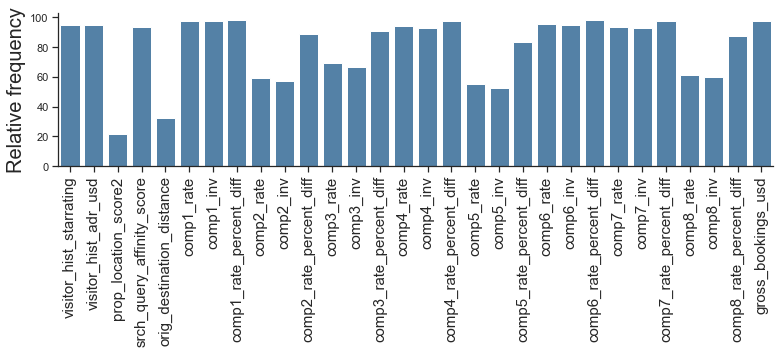

In [9]:
missing_percent = 100 * df.isnull().sum() / df.shape[0]
display(missing_percent)

filled_columns = missing_percent[missing_percent == 0].index.tolist()
print("Non-missing columns:")
display(filled_columns)

non_filled_columns = missing_percent[missing_percent >0.5]
sns.set(rc={'figure.figsize':(11,5)})
sns.set_style("ticks")
fig = sns.barplot(x=non_filled_columns.index, y=non_filled_columns, color='steelblue')
sns.despine()
fig.set_xticklabels(fig.get_xticklabels(), rotation=90, fontdict={'fontsize': 15})
fig.set_ylabel("Relative frequency",fontsize=20)
plt.tight_layout()
plt.savefig('Figures/missing_values.pdf')


### Searches per website

site_id
5     0.609845
14    0.096849
15    0.063645
24    0.050502
32    0.035406
18    0.027198
16    0.019370
12    0.015841
19    0.010070
22    0.009194
9     0.009054
11    0.007092
7     0.006572
29    0.006256
31    0.005656
26    0.003348
4     0.002768
25    0.002658
23    0.002528
1     0.002518
34    0.002087
10    0.001962
13    0.001782
17    0.001296
2     0.001216
27    0.001146
28    0.000936
30    0.000861
21    0.000756
3     0.000746
6     0.000636
33    0.000165
20    0.000035
8     0.000005
Name: srch_id, dtype: float64

[Text(0, 0, '1'),
 Text(1, 0, '2'),
 Text(2, 0, '3'),
 Text(3, 0, '4'),
 Text(4, 0, '5'),
 Text(5, 0, '6'),
 Text(6, 0, '7'),
 Text(7, 0, '8'),
 Text(8, 0, '9'),
 Text(9, 0, '10'),
 Text(10, 0, '11'),
 Text(11, 0, '12'),
 Text(12, 0, '13'),
 Text(13, 0, '14'),
 Text(14, 0, '15'),
 Text(15, 0, '16'),
 Text(16, 0, '17'),
 Text(17, 0, '18'),
 Text(18, 0, '19'),
 Text(19, 0, '20'),
 Text(20, 0, '21'),
 Text(21, 0, '22'),
 Text(22, 0, '23'),
 Text(23, 0, '24'),
 Text(24, 0, '25'),
 Text(25, 0, '26'),
 Text(26, 0, '27'),
 Text(27, 0, '28'),
 Text(28, 0, '29'),
 Text(29, 0, '30'),
 Text(30, 0, '31'),
 Text(31, 0, '32'),
 Text(32, 0, '33'),
 Text(33, 0, '34')]

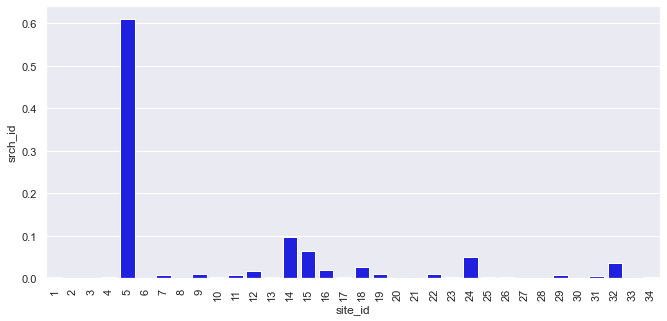

In [10]:
groupby_website = df.groupby('site_id')['srch_id'].nunique() / df['srch_id'].nunique()

site_searches =  groupby_website.sort_values(ascending=False)
display(site_searches)
# site 5 == 'expedia.com'??

sns.set(rc={'figure.figsize':(11,5)})
fig = sns.barplot(x=site_searches.index, y=site_searches, color='blue')
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)

C:\Users\Jaimie\Anaconda3\envs\DMT\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


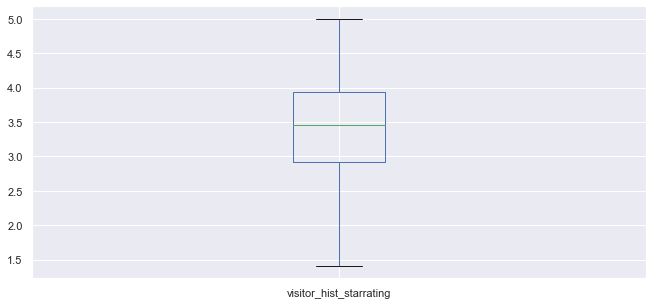

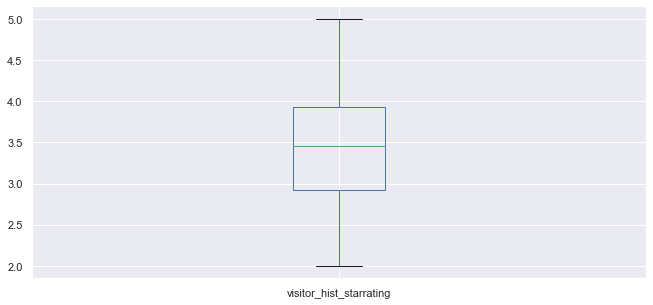

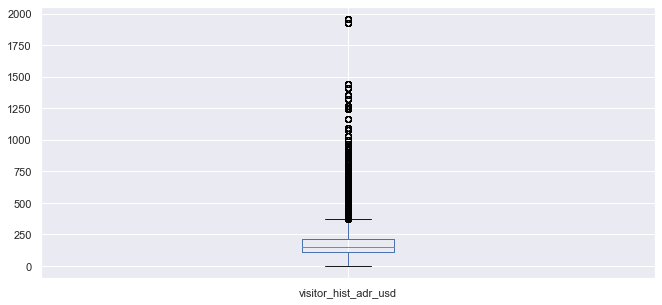

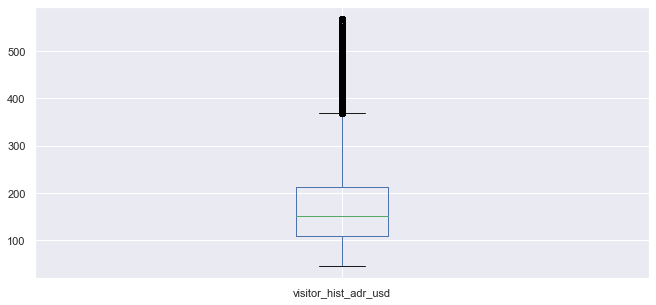

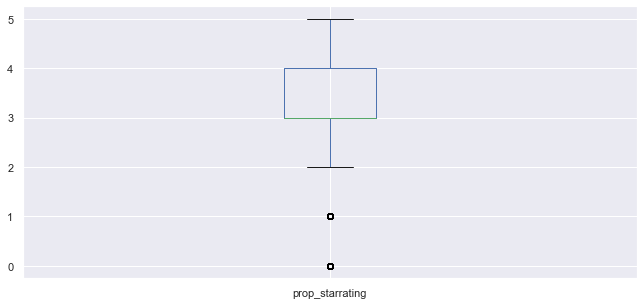

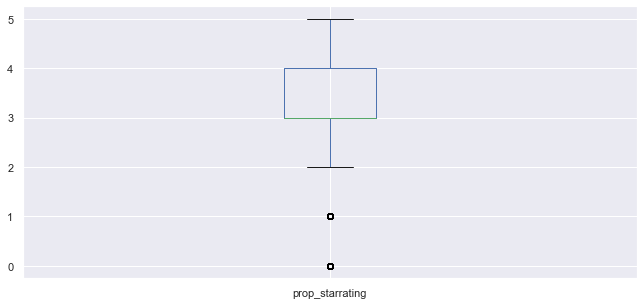

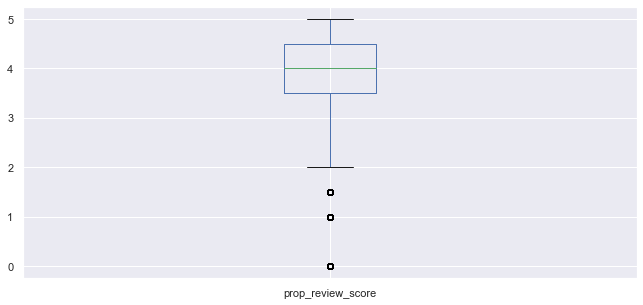

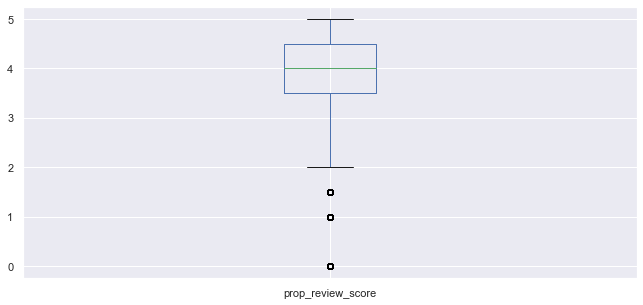

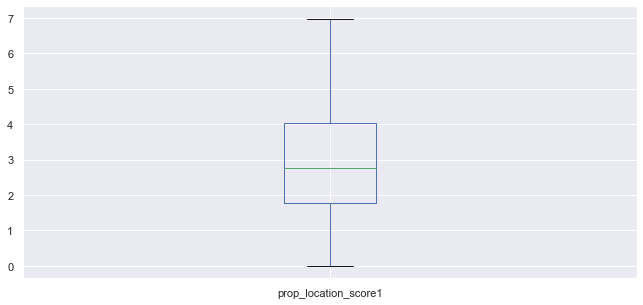

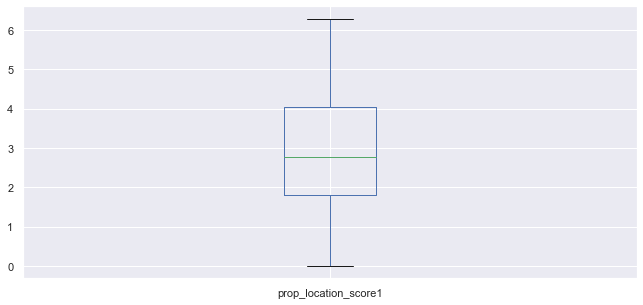

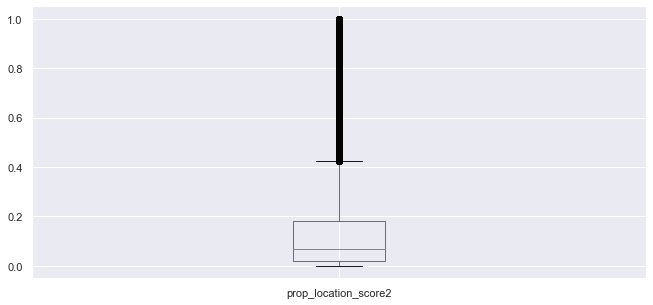

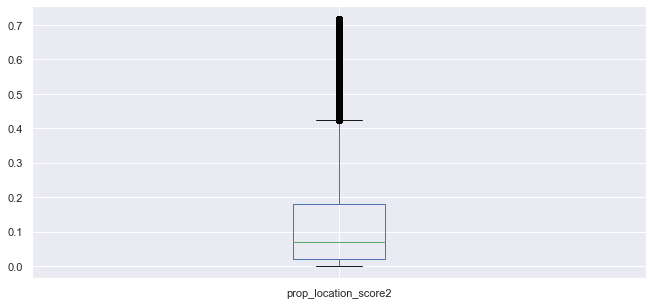

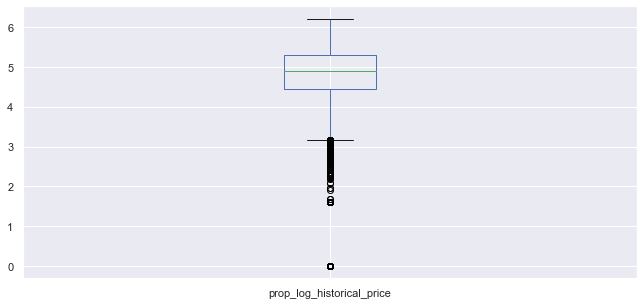

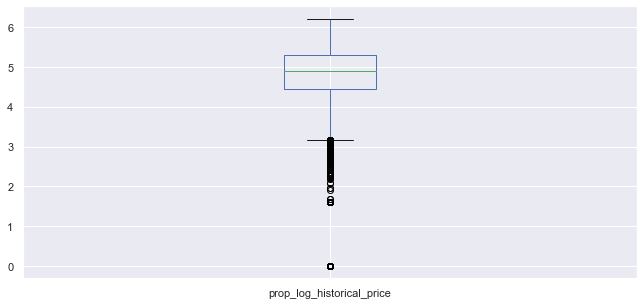

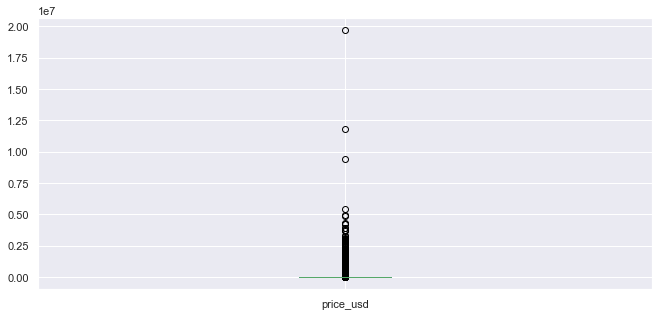

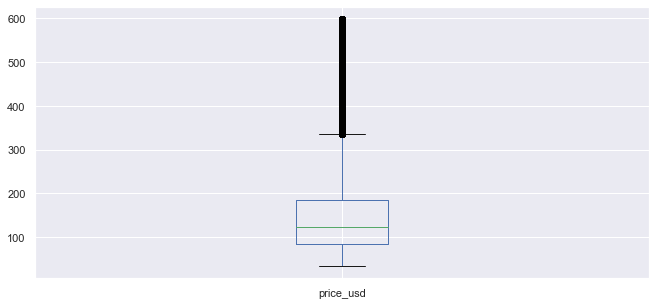

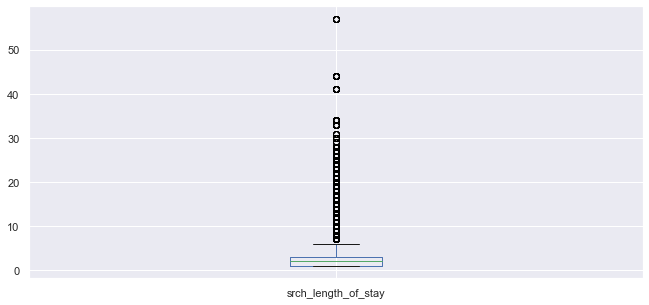

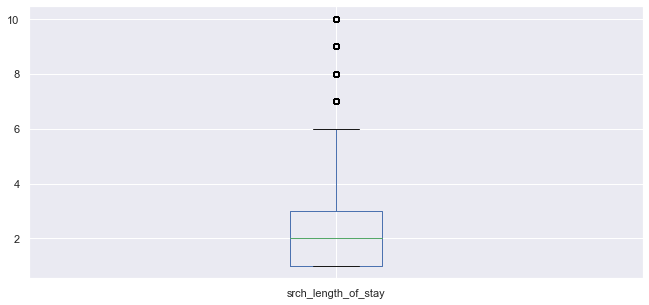

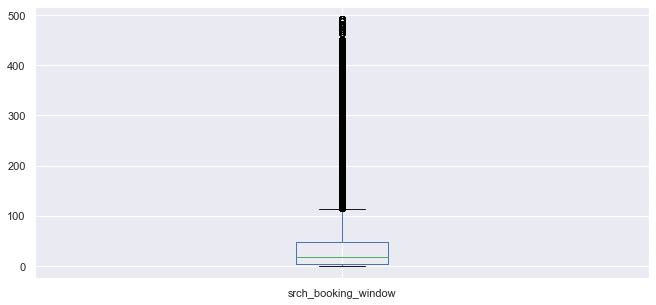

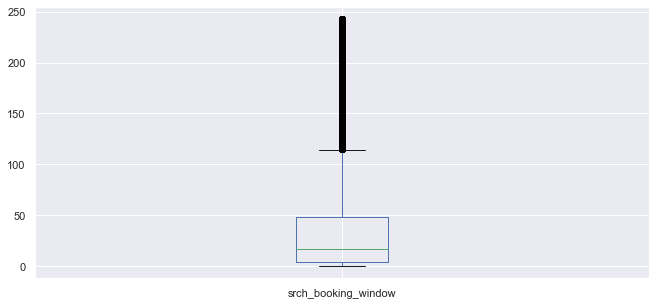

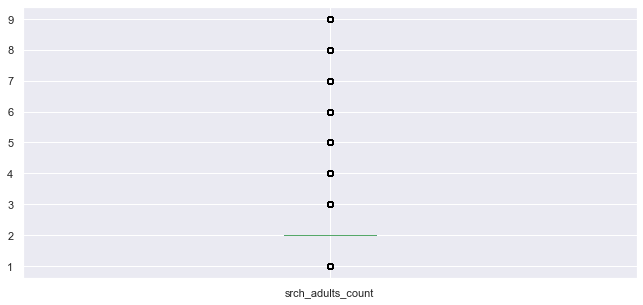

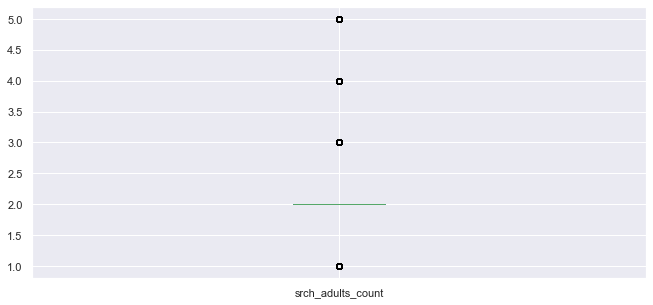

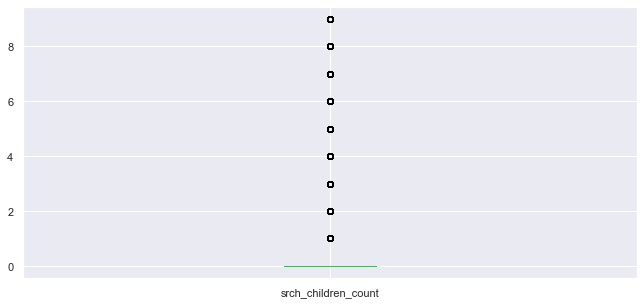

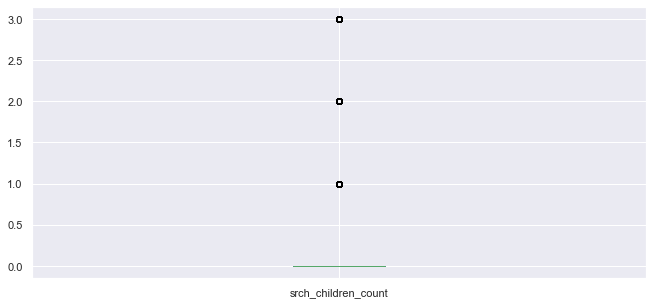

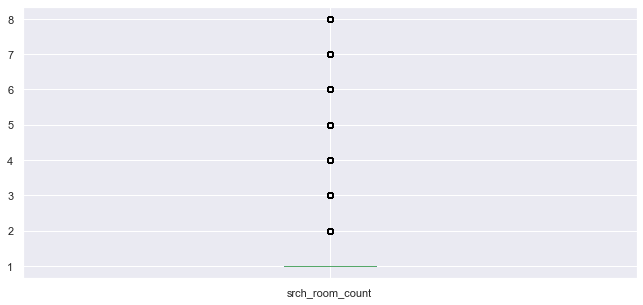

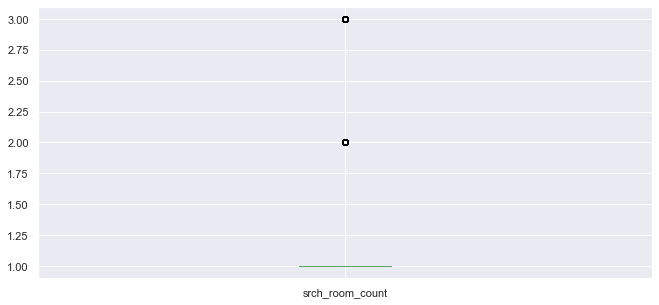

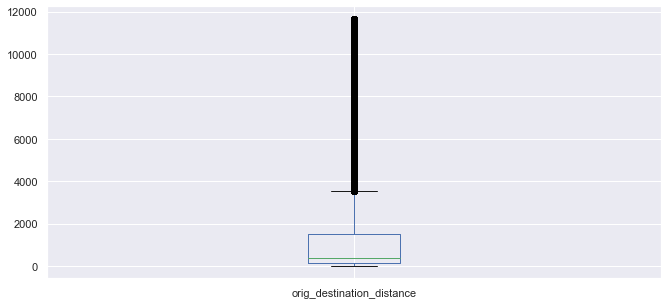

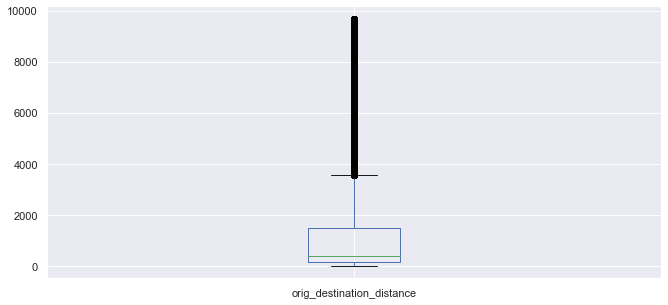

In [11]:
df.columns
numerical_cols = ['visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_starrating', 'prop_review_score', 'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'price_usd', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count',
                 'orig_destination_distance']

for col in numerical_cols:
    alpha=0.01
    df_col = df[col]
    plt.figure()
    df_col.plot.box()
    df_col_winsor = df_col.clip(lower=df_col.quantile(alpha), upper=df_col.quantile(1-alpha))
    plt.figure()
    df_col_winsor.plot.box()
    

#     for column in df:
#     df.boxplot([column])

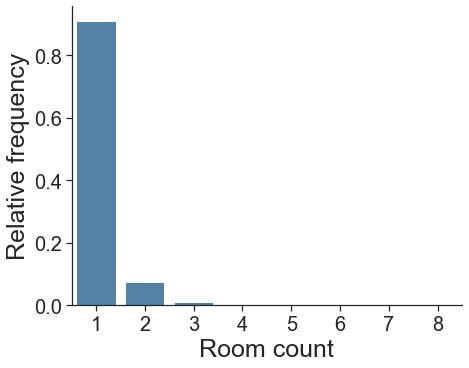

In [12]:
# significant_stay = df['srch_length_of_stay'].loc[df['srch_length_of_stay'] <= 10]
room_count_percent = df['srch_room_count'].value_counts(normalize=True)

sns.set(rc={'figure.figsize':(7,5.5)})

sns.set_style("ticks")
ax = sns.barplot(x=room_count_percent.index, y=room_count_percent, color='steelblue')
sns.despine()
ax.set_xlabel("Room count",fontsize=25)
ax.set_ylabel("Relative frequency",fontsize=25)
ax.tick_params(labelsize=20)
plt.savefig('Figures/room_count.pdf')

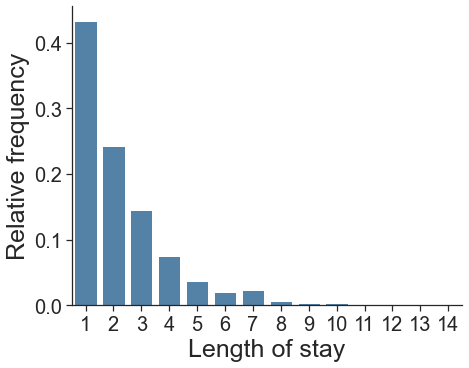

In [13]:
los_percent = df['srch_length_of_stay'].loc[df['srch_length_of_stay'] <= 14].value_counts(normalize=True)
# print(significant_stay_percent)

sns.set(rc={'figure.figsize':(7,5.5)})

sns.set_style("ticks")
ax = sns.barplot(x=los_percent.index, y=los_percent, color='steelblue')
sns.despine()
ax.set_xlabel("Length of stay",fontsize=25)
ax.set_ylabel("Relative frequency",fontsize=25)
ax.tick_params(labelsize=20)
plt.savefig('Figures/los.pdf')
# sns.distplot(df['srch_booking_window'], bins = range(1,14), kde=False, norm_hist=True, color='steelblue', hist_kws=dict(alpha=1), axlabel='Length of stay')


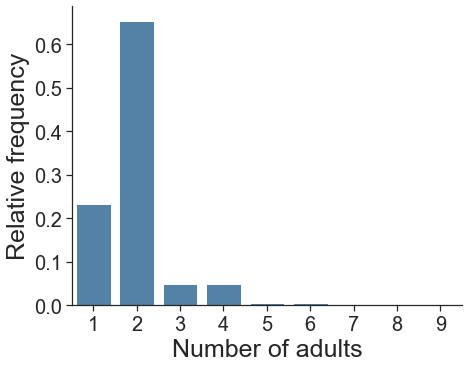

In [14]:
adult_percent = df['srch_adults_count'].value_counts(normalize=True)

# print(significant_stay_percent)

sns.set(rc={'figure.figsize':(7,5.5)})

sns.set_style("ticks")
ax = sns.barplot(x=adult_percent.index, y=adult_percent, color='steelblue')
sns.despine()
ax.set_xlabel("Number of adults",fontsize=25)
ax.set_ylabel("Relative frequency",fontsize=25)
ax.tick_params(labelsize=20)
plt.savefig('Figures/num_adults.pdf')

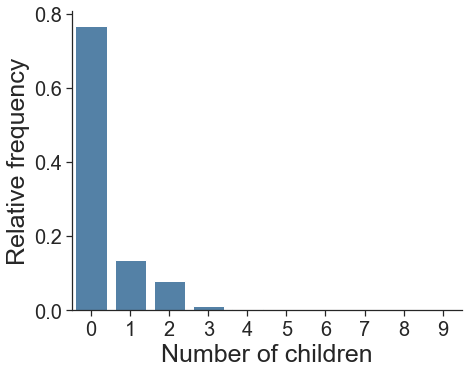

In [15]:
child_percent = df['srch_children_count'].value_counts(normalize=True)

# print(significant_stay_percent)

sns.set(rc={'figure.figsize':(7,5.5)})

sns.set_style("ticks")
ax = sns.barplot(x=child_percent.index, y=child_percent, color='steelblue')
sns.despine()
ax.set_xlabel("Number of children",fontsize=25)
ax.set_ylabel("Relative frequency",fontsize=25)
ax.tick_params(labelsize=20)
plt.savefig('Figures/num_children.pdf')

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate'

C:\Users\Jaimie\Anaconda3\envs\DMT\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


<AxesSubplot:>

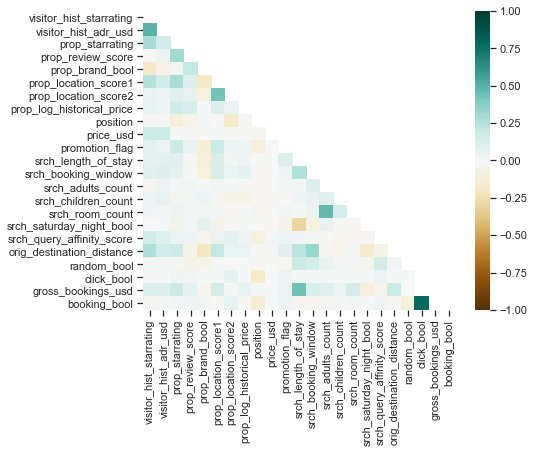

In [16]:
print(df.columns)
relevant_cols = ['visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_starrating', 'prop_review_score', 'prop_brand_bool', 'prop_location_score1', 
                 'prop_location_score2', 'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag', 'srch_length_of_stay', 'srch_booking_window',
                 'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool', 'srch_query_affinity_score', 'orig_destination_distance', 
                 'random_bool', 'click_bool', 'gross_bookings_usd', 'booking_bool']
df_relevant = df[relevant_cols]
mask = np.triu(np.ones_like(df_relevant.corr(), dtype=np.bool))

sns.heatmap(df_relevant.corr(), mask=mask, vmin=-1, vmax=1, cmap='BrBG')

In [17]:
def average_compare(columns):
    df_output_latex = pd.DataFrame(columns=['Column', 'Not clicked or booked', 'Clicked but not booked', 'Booked'])
    for column in columns:      
        not_clicked_not_booked = df.loc[(df.click_bool==0) & (df.booking_bool==0)][column].mean()
        clicked_not_booked = df.loc[(df.click_bool==1) & (df.booking_bool==0)][column].mean()
        clicked_and_booked = df.loc[df.booking_bool==1][column].mean()
        
        df_output_latex = df_output_latex.append({'Column':column, 'Not clicked or booked':round(not_clicked_not_booked, 2), 'Clicked but not booked':round(clicked_not_booked, 2), 'Booked':round(clicked_and_booked,2)}, ignore_index=True)
        
    print(df_output_latex.to_latex(index=False, bold_rows=True))

In [18]:
comparison_cols = ['prop_starrating', 'prop_review_score', 'prop_location_score1', 
                 'prop_location_score2', 'prop_log_historical_price', 'price_usd', 'promotion_flag', 'random_bool']
average_compare(comparison_cols)

\begin{tabular}{lrrr}
\toprule
                   Column &  Not clicked or booked &  Clicked but not booked &  Booked \\
\midrule
          prop\_starrating &                   3.17 &                    3.36 &    3.31 \\
        prop\_review\_score &                   3.77 &                    3.81 &    3.94 \\
     prop\_location\_score1 &                   2.87 &                    2.96 &    2.84 \\
     prop\_location\_score2 &                   0.13 &                    0.17 &    0.19 \\
prop\_log\_historical\_price &                   4.32 &                    4.41 &    4.31 \\
                price\_usd &                 252.44 &                  343.95 &  260.51 \\
           promotion\_flag &                   0.21 &                    0.27 &    0.30 \\
              random\_bool &                   0.30 &                    0.73 &    0.06 \\
\bottomrule
\end{tabular}



### Clicks/Books per position, grouped by random_bool

In [19]:
# groupby_random_bool = df.groupby('random_bool')[['click_bool', 'booking_bool']].count()
groupby_position = df.groupby(['random_bool', 'position'])[['click_bool', 'booking_bool']].sum()
groupby_random_bool = groupby_position.groupby('random_bool').sum()
click_book_ratio = groupby_position / groupby_random_bool
display(groupby_position)
display(groupby_random_bool)
display(click_book_ratio)

click_bool  booking_bool
random_bool position                          
0           1              29908         27014
            2              20271         17976
            3              15381         13385
            4              12267         10593
            5                149            98
...                          ...           ...
1           36               308            25
            37               157            12
            38                32             4
            39                 7             2
            40                 0             0

[80 rows x 2 columns]

,click_bool,booking_bool
random_bool,,
0,153502,130578
1,68377,7812


click_bool  booking_bool
random_bool position                          
0           1           0.194838      0.206880
            2           0.132057      0.137665
            3           0.100201      0.102506
            4           0.079914      0.081124
            5           0.000971      0.000751
...                          ...           ...
1           36          0.004504      0.003200
            37          0.002296      0.001536
            38          0.000468      0.000512
            39          0.000102      0.000256
            40          0.000000      0.000000

[80 rows x 2 columns]

### Location distributions

In [20]:
groupby_home_country = df.groupby('visitor_location_country_id')['srch_id'].nunique()
distribution_home_country = 100 * (groupby_home_country / df['srch_id'].nunique()).sort_values(ascending=False)
display(distribution_home_country)
# Country 219 == USA??
# Country 100 == UK?? => Ursu (2015) suggests South-korea

groupby_prop_country = df.groupby('prop_country_id')['srch_id'].nunique()
distribution_prop_country = 100 * (groupby_prop_country / df['srch_id'].nunique()).sort_values(ascending=False)
display(distribution_prop_country)

groupby_destination_id = df.groupby('srch_destination_id')['srch_id'].nunique()
distribution_destination_id = 100 * (groupby_destination_id / df['srch_id'].nunique()).sort_values(ascending=False)
display(distribution_destination_id)

# 8192 == NYC??
# 4562 == LA?? Miami??

visitor_location_country_id
219    57.151580
100     9.974724
55      5.956606
216     4.602217
220     3.479066
         ...    
67      0.000501
83      0.000501
94      0.000501
101     0.000501
58      0.000501
Name: srch_id, Length: 210, dtype: float64

prop_country_id
219    59.694687
100     6.304963
55      3.899997
31      3.142221
99      2.876949
         ...    
7       0.001001
165     0.001001
204     0.000501
135     0.000501
126     0.000501
Name: srch_id, Length: 172, dtype: float64

srch_destination_id
8192     1.233264
4562     1.020046
9402     0.689707
10979    0.620136
8347     0.596612
           ...   
19543    0.000501
19542    0.000501
19540    0.000501
9199     0.000501
14212    0.000501
Name: srch_id, Length: 18127, dtype: float64

### Drop Columns

In [21]:
competitor_cols = []
for i in range(1, 9):
    competitor_cols += [f'comp{i}_rate', f'comp{i}_inv', f'comp{i}_rate_percent_diff']
drop_cols = competitor_cols + ['gross_bookings_usd', 'position']

df_stage1 = df.drop(columns=drop_cols)

### More Drops:

In [22]:
# left-over with missings
left_overs = [col
              for col in df_stage1.columns
              if not col in filled_columns]
print("Left-over columns for drop/imputation")
display(missing_percent[left_overs])
drop_cols_extra = ['visitor_hist_starrating', 'visitor_hist_adr_usd', 'srch_query_affinity_score']  # voor nu even droppen
df_stage1.drop(columns=drop_cols_extra, inplace=True)


Left-over columns for drop/imputation


visitor_hist_starrating      94.920364
visitor_hist_adr_usd         94.897735
prop_review_score             0.148517
prop_location_score2         21.990151
srch_query_affinity_score    93.598552
orig_destination_distance    32.425766
dtype: float64

## Fill Na
### TODO: prop_review_score use lower quantile impute? per DMT 2020 group 95
#### prop_location_score2 imputed per country, lower quantile as baseline => cited by group 95 and Liu et al

In [23]:
df_stage1['prop_review_score'] = df_stage1['prop_review_score'].fillna(0)   # set no available to 0 reviews

prop_score = df_stage1.groupby('prop_id')['prop_review_score'].max()
no_reviews = prop_score[prop_score == 0].index
print(f"% properties with no reviews {100 * len(no_reviews) / len(prop_score)}")

% properties with no reviews 24.453773051513014


### Orig_destination_distance completion:


In [24]:
srch_grouped = df.groupby('srch_id')['visitor_location_country_id', 'prop_country_id', 'prop_id', 'srch_destination_id',
'orig_destination_distance'].first()
display(srch_grouped.head(10))

C:\Users\Jaimie\Anaconda3\envs\DMT\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,visitor_location_country_id,prop_country_id,prop_id,srch_destination_id,orig_destination_distance
srch_id,,,,,
1,187,219,893,23246,NaN
4,219,219,3625,12588,238.35
6,100,100,10759,21106,652.84
8,219,219,10250,7082,5.40
11,219,219,6492,12610,284.56
12,219,158,7814,26648,9270.55
17,129,31,2196,6285,433.61
21,55,216,6225,18161,NaN
25,219,219,2863,3735,766.18


In [25]:
# Test if this is country to country distance:
same_country = srch_grouped[srch_grouped['visitor_location_country_id'] == srch_grouped['prop_country_id']]
same_country_dist = same_country.groupby('visitor_location_country_id')['orig_destination_distance'].agg(['mean', 'std'])

relative_dist_std = same_country_dist['std'] / same_country_dist['mean']
display(relative_dist_std)
display(relative_dist_std[~relative_dist_std.isnull()])

# Contains large distances thus not country-country distance

visitor_location_country_id
1           NaN
2           NaN
4      0.270093
9           NaN
10     2.129486
         ...   
221         NaN
223         NaN
224         NaN
229         NaN
230         NaN
Length: 112, dtype: float64

visitor_location_country_id
4      0.270093
10     2.129486
31     0.705495
32     0.841692
50     1.002795
53     0.006011
55     0.766841
59     0.934761
100    1.510248
129    0.551630
158    0.877572
202    0.541477
215    0.804445
219    1.248095
220    1.084706
dtype: float64

In [26]:
# use median distance country-country to impute distance
df_country_dist = df[['visitor_location_country_id', 'prop_country_id', 'orig_destination_distance']]
df_country_dist = df_country_dist.set_index(['visitor_location_country_id', 'prop_country_id']).sort_index().dropna()

In [27]:
combin_dist = df_country_dist.groupby(['visitor_location_country_id', 'prop_country_id'])['orig_destination_distance'].apply(np.array)

# concat (a, b) and (b, a) distances:
c2c_arrays = dict()
for i, (c1, c2) in enumerate(combin_dist.index):
    vDist = combin_dist.values[i]

    if (c2, c1) in c2c_arrays:
        c2c_arrays[(c2, c1)] = np.append(c2c_arrays[(c2, c1)], vDist)
        continue

    c2c_arrays[c1, c2] = vDist

c2c_median = [dict(c1=c1, c2=c2, median_dist=np.median(vDist)) for (c1, c2), vDist in c2c_arrays.items()]

In [28]:
df_c2c_median = pd.DataFrame(c2c_median)

# concat df with swapped c1, c2 to accomodate simple merge
df_c2c_median2 = pd.concat([df_c2c_median, df_c2c_median.rename(columns={'c1': 'c2', 'c2': 'c1'})], axis=0).drop_duplicates()

print(df_c2c_median.shape[0])
print(df_c2c_median2.shape[0])
display(df_c2c_median.head(5))

example = df_c2c_median2[((df_c2c_median2['c1'] == 4) & (df_c2c_median2['c2'] == 55)) | ((df_c2c_median2['c1'] == 55) & (df_c2c_median2['c2'] == 4)) ]
display(example)


791
1567


,c1,c2,median_dist
0,4,4,137.005
1,4,55,355.590
2,4,73,557.550
3,4,98,6509.850
4,4,99,862.630


,c1,c2,median_dist
1,4,55,355.59
1,55,4,355.59


In [29]:
df_joint_dist = pd.merge(df_stage1, df_c2c_median2, left_on=['visitor_location_country_id', 'prop_country_id'], right_on=['c1', 'c2'], how='left')

In [30]:
nan_mask = df_joint_dist['orig_destination_distance'].isnull()
df_joint_dist.loc[nan_mask, 'orig_destination_distance'] = df_joint_dist.loc[nan_mask, 'median_dist']

missing = df_joint_dist['orig_destination_distance'].isnull().sum() / df_joint_dist.shape[0]
print(missing)


0.09513815793852266


### Still 10% missing distances
#### TODO: use median of median to complete nan's


In [31]:
median_of_median = df_c2c_median['median_dist'].median()
print(median_of_median)
df_joint_dist['orig_destination_distance'].fillna(median_of_median, inplace=True)

4580.98


In [32]:
df_stage1 = df_joint_dist.drop(columns=df_c2c_median2.columns)


In [33]:
# grouped by 'srch_destination_id' (city) would be more precise, but still has some NaN's
country_score2 = df_stage1.groupby('prop_country_id')['prop_location_score2'].quantile(0.25)

score2_country_join = pd.merge(df_stage1, country_score2, on='prop_country_id', how='left')['prop_location_score2_y']
print(f"Still {score2_country_join.isnull().sum()} unsolved NaN's")

# Fill 2 left-overs
score2_country_join[score2_country_join.isnull()] = country_score2.mean()
print(f"Still {score2_country_join.isnull().sum()} unsolved NaN's")

df_stage2 = df_stage1.copy()
nan_mask = df_stage2['prop_location_score2'].isnull()
display(nan_mask)
df_stage2.loc[nan_mask, 'prop_location_score2'] = score2_country_join[nan_mask]

Still 2 unsolved NaN's
Still 0 unsolved NaN's


0          False
1          False
2          False
3          False
4          False
           ...  
4958342    False
4958343    False
4958344    False
4958345    False
4958346     True
Name: prop_location_score2, Length: 4958347, dtype: bool

In [34]:
# Group 95 does not give an alpha => this needs reasoning
alpha = 0.01
price_usd = df_stage2['price_usd']
price_usd_winsorized = price_usd.clip(lower=price_usd.quantile(alpha), upper=price_usd.quantile(1-alpha))


length_of_stay = df_stage2['srch_length_of_stay']
length_of_stay_winsorized = length_of_stay.clip(lower=length_of_stay.quantile(alpha), upper=length_of_stay.quantile(1-alpha))
booking_window = df_stage2['srch_booking_window']
booking_window_winsorized = booking_window.clip(lower=booking_window.quantile(alpha), upper=booking_window.quantile(1-alpha))

display(price_usd_winsorized)
outliers = price_usd[price_usd != price_usd_winsorized]
display(outliers)

df_stage3 = df_stage2.copy()
df_stage3['price_usd'] = price_usd_winsorized
df_stage3['srch_length_of_stay'] = length_of_stay_winsorized
df_stage3['srch_booking_window'] = booking_window_winsorized

0          104.77
1          170.74
2          179.80
3          599.00
4          143.58
            ...  
4958342    118.00
4958343     89.00
4958344     99.00
4958345    139.00
4958346     61.00
Name: price_usd, Length: 4958347, dtype: float64

3          602.77
32         600.00
126         29.00
130         29.00
137         32.00
            ...  
4958162     23.92
4958164     26.79
4958168     33.49
4958300     24.15
4958305     30.31
Name: price_usd, Length: 98760, dtype: float64

## Temporary output

In [35]:
missing_percent = 100 * df_stage3.isnull().sum() / df_stage3.shape[0]
print("% missing:")
display(missing_percent)

df_stage3.to_pickle('df_temporary.pkl')


% missing:


srch_id                        0.0
date_time                      0.0
site_id                        0.0
visitor_location_country_id    0.0
prop_country_id                0.0
prop_id                        0.0
prop_starrating                0.0
prop_review_score              0.0
prop_brand_bool                0.0
prop_location_score1           0.0
prop_location_score2           0.0
prop_log_historical_price      0.0
price_usd                      0.0
promotion_flag                 0.0
srch_destination_id            0.0
srch_length_of_stay            0.0
srch_booking_window            0.0
srch_adults_count              0.0
srch_children_count            0.0
srch_room_count                0.0
srch_saturday_night_bool       0.0
orig_destination_distance      0.0
random_bool                    0.0
click_bool                     0.0
booking_bool                   0.0
dtype: float64

Check class inbalance:

In [36]:
df.groupby('click_bool')['srch_id'].count()

click_bool
0    4736468
1     221879
Name: srch_id, dtype: int64

In [37]:
df.groupby('booking_bool')['srch_id'].count()

booking_bool
0    4819957
1     138390
Name: srch_id, dtype: int64

In [38]:
print('Total instances not clicked and not booked = ', df.groupby('click_bool')['srch_id'].count()[0])
print('Total instances clicked but not booked = ', (df.groupby('click_bool')['srch_id'].count()[1]-df.groupby('booking_bool')['srch_id'].count()[1]))
print('Total instances clicked and booked = ', df.groupby('booking_bool')['srch_id'].count()[1])

Total instances not clicked and not booked =  4736468
Total instances clicked but not booked =  83489
Total instances clicked and booked =  138390


In [39]:
#Check if it is true that all instances booked are also clicked:
df[df['booking_bool']==1]['click_bool'].describe()

count    138390.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: click_bool, dtype: float64

In [40]:
def boxplot_compare(column):
    not_clicked_not_booked = df.loc[(df.click_bool==0) & (df.booking_bool==0)][column]
    clicked_not_booked = df.loc[(df.click_bool==1) & (df.booking_bool==0)][column]
    clicked_and_booked = df.loc[df.booking_bool==1][column]
    
    plt.figure(figsize=(10,5))
    sns.boxplot(data=[not_clicked_not_booked, clicked_not_booked, clicked_and_booked])
    plt.xticks(plt.xticks()[0], ['Not clicked or booked', 'Clicked but not booked', 'Booked'])

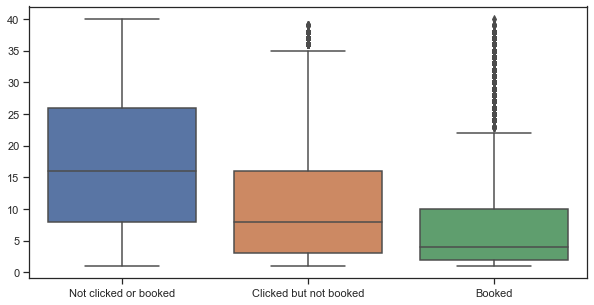

In [41]:
boxplot_compare('position')

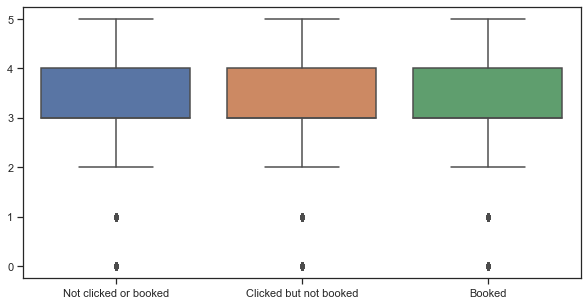

In [42]:
boxplot_compare('prop_starrating')

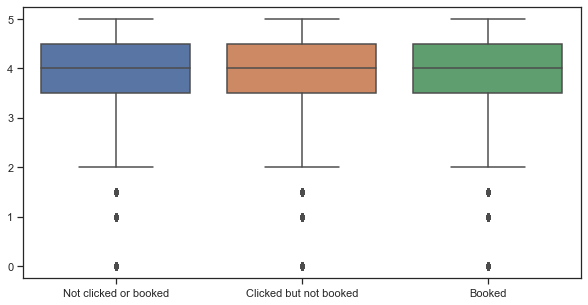

In [43]:
boxplot_compare('prop_review_score')

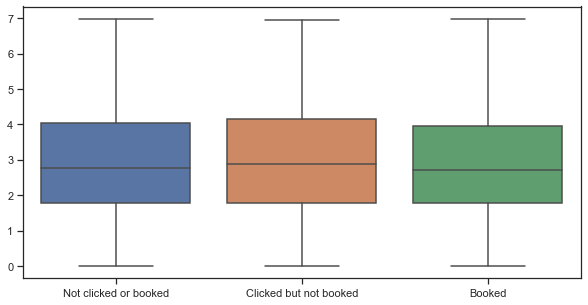

In [44]:
boxplot_compare('prop_location_score1')

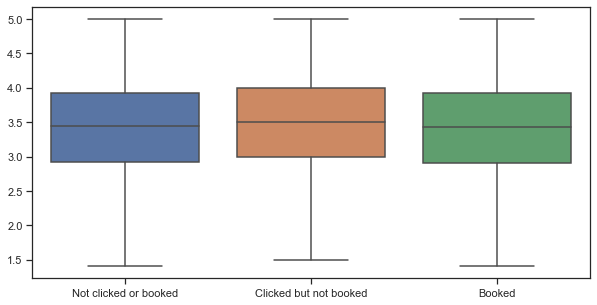

In [45]:
boxplot_compare('visitor_hist_starrating')

In [46]:
df['prop_review_score'].mean()

3.7777767566562033

In [47]:
df.groupby('booking_bool')['promotion_flag'].mean()

booking_bool
0    0.213108
1    0.303107
Name: promotion_flag, dtype: float64

In [48]:
df.groupby('click_bool')['promotion_flag'].mean()

click_bool
0    0.212109
1    0.290559
Name: promotion_flag, dtype: float64

Check if there is a correlation between variables and position:

In [49]:
df_non_random = df[df['random_bool']==0]

<AxesSubplot:xlabel='prop_review_score', ylabel='position'>

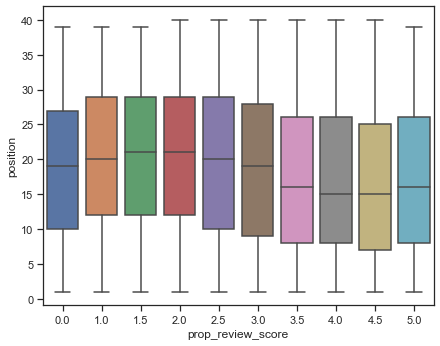

In [50]:
sns.boxplot(x='prop_review_score', y='position', data=df_non_random)

<AxesSubplot:xlabel='prop_starrating', ylabel='position'>

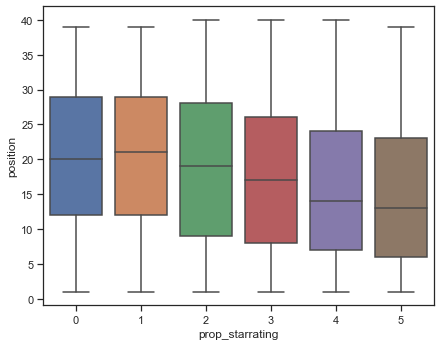

In [51]:
sns.boxplot(x='prop_starrating', y='position', data=df_non_random)

### Bookings seasonality

,date_time,checkin_date
0,2013-04-04 08:32:15,2013-04-04 08:32:15
1,2013-04-04 08:32:15,2013-04-04 08:32:15
2,2013-04-04 08:32:15,2013-04-04 08:32:15
3,2013-04-04 08:32:15,2013-04-04 08:32:15
4,2013-04-04 08:32:15,2013-04-04 08:32:15
...,...,...
4958342,2013-06-30 19:55:18,2013-07-21 19:55:18
4958343,2013-06-30 19:55:18,2013-07-21 19:55:18
4958344,2013-06-30 19:55:18,2013-07-21 19:55:18
4958345,2013-06-30 19:55:18,2013-07-21 19:55:18


checkin_weeknr
1     4537
2     3112
3     3840
4     3465
5     3434
6     4029
7     5308
8     4576
9     4362
10    4868
11    5502
12    5845
13    6671
14    5628
15    4920
16    4973
17    5345
18    5325
19    5235
20    6185
21    7144
22    5596
23    6182
24    6519
25    7352
26    7575
27    6401
28    4389
29    3714
30    3185
31    2722
32    2527
33    2172
34    1590
35    1430
36    1095
37    1136
38    1025
39     728
40     685
41     616
42     490
43     364
44     867
45    2200
46    2697
47    3313
48    2905
49    3107
50    3212
51    3950
52    5747
Name: srch_id, dtype: int64

C:\Users\Jaimie\Anaconda3\envs\DMT\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


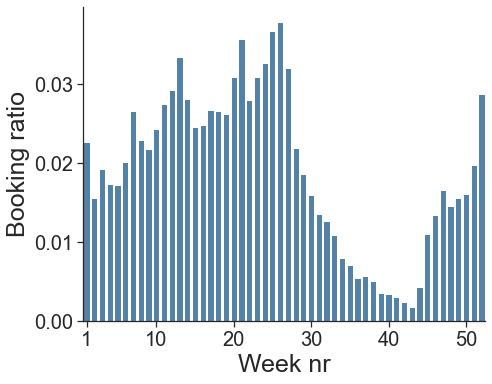

In [52]:
df_stage3['checkin_date'] = df_stage3['date_time'] + pd.to_timedelta(df_stage3['srch_booking_window'], unit='D')  # speedup with vectorize?,
display(df_stage3[['date_time', 'checkin_date']])
df_stage3['checkin_weeknr'] = df_stage3['checkin_date'].dt.isocalendar().week

groupby_weeknr = df_stage3.groupby('checkin_weeknr')['srch_id'].nunique()
distr_weeknr = groupby_weeknr / df_stage3['srch_id'].nunique()
display(groupby_weeknr)

import matplotlib.pyplot as plt
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
x = distr_weeknr.index.tolist()
y = distr_weeknr.values

# ax.bar(x, y, 0.1, color='r')
# ax.set_ylabel('Booking Ratio')
# ax.set_xlabel('Week Nr.')
# ax.set_title('Bookings Seasonality')
# plt.show()

sns.set(rc={'figure.figsize':(7,5.5)})

sns.set_style("ticks")
ax = sns.barplot(x, y, color='steelblue')
sns.despine()
ax.set_xlabel("Week nr",fontsize=25)
ax.set_ylabel("Booking ratio",fontsize=25)
ax.tick_params(labelsize=20)
ax.set(xticks=[0, 9, 19, 29, 39, 49])
plt.tight_layout()
plt.savefig('Figures/seasonality.pdf')

### Date Features

In [53]:
def mine_date_features(dt_series, prefix=''):
        df = pd.DataFrame()
        df['weekday'] = dt_series.dt.weekday
        df['monthday'] = dt_series.dt.day
        df['month'] = dt_series.dt.month
        df['week'] = dt_series.dt.week
        df['year'] = dt_series.dt.year
    
        df.columns = list(map(lambda s: prefix + s, df.columns.tolist()))
        return df

# Feature engineering:

In [54]:
df_stage3['checkout_date'] = df_stage3['checkin_date'] + pd.to_timedelta(df_stage3['srch_length_of_stay'], unit='D')

df_srchdate_features = mine_date_features(df_stage3['date_time'], prefix='srchdate_')
df_srchdate_features['srchdate_hour'] = df_stage3['date_time'].dt.hour

df_checkin_features = mine_date_features(df_stage3['checkin_date'], prefix='checkin_')
df_checkout_features = mine_date_features(df_stage3['checkout_date'], prefix='checkout_')

df_stage4 = pd.concat([df_stage3, df_srchdate_features, df_checkin_features, df_checkout_features], axis=1)
display(df_srchdate_features)
display(df_checkin_features)
display(df_checkout_features)

C:\Users\Jaimie\Anaconda3\envs\DMT\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,srchdate_weekday,srchdate_monthday,srchdate_month,srchdate_week,srchdate_year,srchdate_hour
0,3,4,4,14,2013,8
1,3,4,4,14,2013,8
2,3,4,4,14,2013,8
3,3,4,4,14,2013,8
4,3,4,4,14,2013,8
...,...,...,...,...,...,...
4958342,6,30,6,26,2013,19
4958343,6,30,6,26,2013,19
4958344,6,30,6,26,2013,19
4958345,6,30,6,26,2013,19


,checkin_weekday,checkin_monthday,checkin_month,checkin_week,checkin_year
0,3,4,4,14,2013
1,3,4,4,14,2013
2,3,4,4,14,2013
3,3,4,4,14,2013
4,3,4,4,14,2013
...,...,...,...,...,...
4958342,6,21,7,29,2013
4958343,6,21,7,29,2013
4958344,6,21,7,29,2013
4958345,6,21,7,29,2013


,checkout_weekday,checkout_monthday,checkout_month,checkout_week,checkout_year
0,4,5,4,14,2013
1,4,5,4,14,2013
2,4,5,4,14,2013
3,4,5,4,14,2013
4,4,5,4,14,2013
...,...,...,...,...,...
4958342,0,22,7,30,2013
4958343,0,22,7,30,2013
4958344,0,22,7,30,2013
4958345,0,22,7,30,2013


### Check search hour

In [55]:
print(df_stage4.columns)
from_usa_mask = df_stage4['visitor_location_country_id'] == 219
usa_searches = df_stage4[from_usa_mask]
other_searches = df_stage4[~from_usa_mask]

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'prop_country_id', 'prop_id', 'prop_starrating', 'prop_review_score',
       'prop_brand_bool', 'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'orig_destination_distance', 'random_bool',
       'click_bool', 'booking_bool', 'checkin_date', 'checkin_weeknr',
       'checkout_date', 'srchdate_weekday', 'srchdate_monthday',
       'srchdate_month', 'srchdate_week', 'srchdate_year', 'srchdate_hour',
       'checkin_weekday', 'checkin_monthday', 'checkin_month', 'checkin_week',
       'checkin_year', 'checkout_weekday', 'checkout_monthday',
       'checkout_month', 'checkout_week', 'checkout_year'],
      dtype='object')


C:\Users\Jaimie\Anaconda3\envs\DMT\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


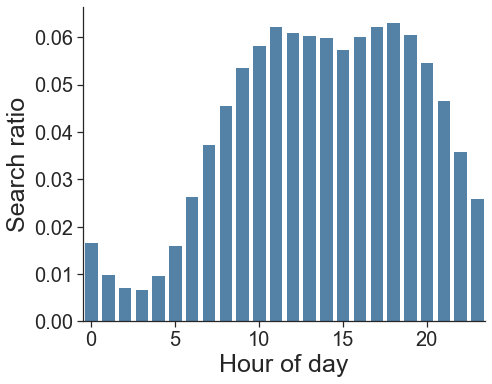

In [56]:
# All countries
df_stage4_srch_distribution = df_stage4.groupby('srchdate_hour')['srch_id'].nunique() / df_stage4['srch_id'].nunique()
x = df_stage4_srch_distribution.index.tolist()
y = df_stage4_srch_distribution.values

sns.set(rc={'figure.figsize':(7,5.5)})

sns.set_style("ticks")
ax = sns.barplot(x, y, color='steelblue')
sns.despine()
ax.set_xlabel("Hour of day",fontsize=25)
ax.set_ylabel("Search ratio",fontsize=25)
ax.tick_params(labelsize=20)
ax.set(xticks=[0, 5, 10, 15, 20])
plt.tight_layout()
plt.savefig('Figures/hourofday.pdf')


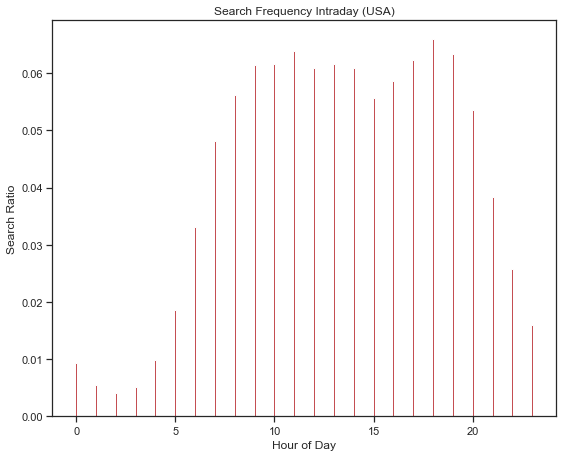

In [57]:
# USA
usa_srchhours = usa_searches.groupby('srchdate_hour')['srch_id'].nunique()
usa_srch_distribution = usa_srchhours / usa_searches['srch_id'].nunique()

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = usa_srch_distribution.index.tolist()
y = usa_srch_distribution.values

ax.bar(x, y, 0.1, color='r')
ax.set_ylabel('Search Ratio')
ax.set_xlabel('Hour of Day')
ax.set_title('Search Frequency Intraday (USA)')
plt.show()

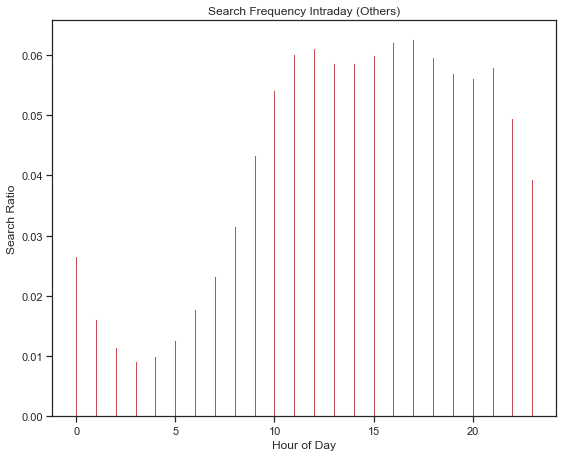

In [58]:
# Other origin countries
other_srchhours = other_searches.groupby('srchdate_hour')['srch_id'].nunique()
other_srch_distribution = other_srchhours / other_searches['srch_id'].nunique()


import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = other_srch_distribution.index.tolist()
y = other_srch_distribution.values

ax.bar(x, y, 0.1, color='r')
ax.set_ylabel('Search Ratio')
ax.set_xlabel('Hour of Day')
ax.set_title('Search Frequency Intraday (Others)')
plt.show()

# TODO: compare

#### Time could be in local timezone but the distributions should be equal in that case
#### USA not suitable for comparison due to different time zones between East/West coast
#### ML model could derive relation hour of day and the origin country
#### Time zone could use indebt analysis

### Count # of weekdays contained in booking_window (i.e. Sun: 1, Sat: 1, mon: 1, tue: 0, wed: 0 ...)

In [59]:
import calendar
def dayofweek_count(dt_start, dt_end):
    dt_range = pd.date_range(dt_start, dt_end, freq='d')

    cnt = {day: 0 for day in calendar.day_name}
    for date in dt_range:
        cnt[date.day_name()] += 1
    return pd.Series(cnt)

In [60]:
srch_grouped = df_stage4.groupby('srch_id').first()
srch_window = pd.DataFrame(srch_grouped[['checkin_date', 'checkout_date']])
display(srch_window)

,checkin_date,checkout_date
srch_id,,
1,2013-04-04 08:32:15,2013-04-05 08:32:15
4,2013-02-15 08:59:22,2013-02-17 08:59:22
6,2013-06-10 12:27:51,2013-06-11 12:27:51
8,2013-03-20 17:50:44,2013-03-21 17:50:44
11,2013-04-05 08:39:33,2013-04-06 08:39:33
...,...,...
332777,2013-06-02 10:40:02,2013-06-07 10:40:02
332781,2013-03-08 15:12:59,2013-03-10 15:12:59
332782,2012-11-10 18:24:21,2012-11-12 18:24:21


In [61]:
srch_daycounts = srch_window.apply(lambda df: dayofweek_count(df['checkin_date'], df['checkout_date']), axis=1)

display(srch_daycounts)

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
srch_id,,,,,,,
1,0,0,0,1,1,0,0
4,0,0,0,0,1,1,1
6,1,1,0,0,0,0,0
8,0,0,1,1,0,0,0
11,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...
332777,1,1,1,1,1,0,1
332781,0,0,0,0,1,1,1
332782,1,0,0,0,0,1,1


In [62]:
df_stage5 = pd.merge(df_stage4, srch_daycounts, on='srch_id', how='left')
display(df_stage5.head())

,srch_id,date_time,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,...,checkout_month,checkout_week,checkout_year,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,1,2013-04-04 08:32:15,12,187,219,893,3,3.5,1,2.83,...,4,14,2013,0,0,0,1,1,0,0
1,1,2013-04-04 08:32:15,12,187,219,10404,4,4.0,1,2.20,...,4,14,2013,0,0,0,1,1,0,0
2,1,2013-04-04 08:32:15,12,187,219,21315,3,4.5,1,2.20,...,4,14,2013,0,0,0,1,1,0,0
3,1,2013-04-04 08:32:15,12,187,219,27348,2,4.0,1,2.83,...,4,14,2013,0,0,0,1,1,0,0
4,1,2013-04-04 08:32:15,12,187,219,29604,4,3.5,1,2.64,...,4,14,2013,0,0,0,1,1,0,0


In [63]:
# Check if join is correct
print(df_stage4.shape)
print(df_stage5.shape)
missings = df_stage5[list(calendar.day_name)].isnull().sum() / df_stage5.shape[0]
print(missings)


(4958347, 44)
(4958347, 51)
Monday       0.0
Tuesday      0.0
Wednesday    0.0
Thursday     0.0
Friday       0.0
Saturday     0.0
Sunday       0.0
dtype: float64


### Holiday Features (if contained in booking window)

In [64]:
import holidays
holidays = holidays.UnitedStates(years=[2012, 2013, 2014, 2015, 2016])  # easter is missing but fuck that

In [65]:
from collections import defaultdict
def booking_contains_holidays(dt_start, dt_end, holidays):
    dt_range = [dt.date() for dt in pd.date_range(dt_start, dt_end, freq='D')]

    contained = defaultdict(int)
    for dt_holiday, name_holiday in holidays.items():
        if contained[name_holiday]: # prevents override of holiday from another year
            continue
        contained[name_holiday] = int(dt_holiday in dt_range)

    return pd.Series(contained)

In [66]:
srch_holidays = srch_window.apply(lambda df: booking_contains_holidays(df['checkin_date'], df['checkout_date'], holidays), axis=1)

In [67]:
nr_of_holidays = (srch_holidays == True).sum()
print(nr_of_holidays)

New Year's Day                 3133
Martin Luther King Jr. Day     1625
Washington's Birthday          2165
Memorial Day                   3244
Independence Day               3501
Labor Day                       817
Columbus Day                    337
Veterans Day                   1184
Thanksgiving                   1449
Christmas Day                  1983
Christmas Day (Observed)          0
New Year's Day (Observed)         0
Veterans Day (Observed)         738
Independence Day (Observed)       0
dtype: int64


In [68]:
df_stage6 = pd.merge(df_stage5, srch_holidays, on='srch_id', how='left')

### Pricing features

#### Last known property price + difference

In [69]:
df_prop = df[['prop_id', 'srch_id', 'date_time', 'price_usd']].sort_values(['prop_id', 'date_time'])

df_prop['last_price'] = df_prop.groupby('prop_id')['price_usd'].shift().fillna(df_prop['price_usd'])  # use same price
df_prop['diff_last_price'] = (df_prop['price_usd'] - df_prop['last_price']) / df_prop['last_price']
df_prop['diff_last_price'].fillna(0, inplace=True)
display(df_prop.head())

,prop_id,srch_id,date_time,price_usd,last_price,diff_last_price
4335788,1,290885,2012-11-04 07:03:31,89.0,89.0,0.00000
2579011,1,173183,2012-11-06 08:58:26,89.0,89.0,0.00000
3728222,1,250387,2012-11-08 04:09:33,99.0,89.0,0.11236
2665876,1,178899,2012-11-09 12:49:16,99.0,99.0,0.00000
122212,1,8178,2012-11-17 08:14:07,89.0,99.0,-0.10101


#### Expanded min, max, median, std, mean + their difference

In [70]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    return percentile_

In [ ]:
aggregates = {f'{fn}_price': fn
              for fn in ['min', 'max', 'median', 'std', 'mean', 'count']}
aggregates.update({'price_percentile_25%': percentile(25), 'price_percentile_75%': percentile(75)})

# TODO: Better fill na !!
df_prop[list(aggregates.keys())] = df_prop.groupby('prop_id')['price_usd'].expanding().agg(list(aggregates.values())).fillna(0).values

In [ ]:
diff_ignore = ['std', 'count']
for col_name, fn in aggregates.items():
    if fn in diff_ignore:  # doesn't make sense
        continue

    df_prop[f'diff_{col_name}'] = (df_prop['price_usd'] - df_prop[col_name]) / df_prop[col_name]
    df_prop[f'diff_{col_name}'].fillna(0, inplace=True)

df_prop.replace(np.inf, 0, inplace=True)
print(df_prop.shape)
display(df_prop.head(65))

# drop price_usd to avoid duplicates
df_prop.drop(columns=['price_usd'], inplace=True)

In [ ]:
df_stage7 = pd.merge(df_stage6, df_prop, on=['srch_id', 'prop_id', 'date_time'], how='left')
print(df_stage7.shape)
display(df_stage7.head(65))

## Features output

In [ ]:
df_stage7.drop(columns=['date_time', 'checkin_date', 'checkout_date'], inplace=True)
display(df_stage7.columns)
display(df_stage7.describe())

In [ ]:
describ = df_stage7.describe()

In [ ]:
df_stage7.to_pickle('df_features.pkl')

In [ ]:
# TODO: price difference whole dataset => Ursu (2015) suggests cheaper properties have more clicks